# Object Detection

Finding the localized area in which an object presides from two points, the bottom left and top right

![](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/06/maxresdefault.jpg)

# The Data

Before we begin training, let's focus on how to build the `DataLoader`. We'll want to use the `Pascal_VOC` dataset today

In [1]:
from fastai2.vision.all import *

In [2]:
path = untar_data(URLs.PASCAL_2007)

In [3]:
path.ls()

(#8) [Path('/home/jaidmin/.fastai/data/pascal_2007/train.csv'),Path('/home/jaidmin/.fastai/data/pascal_2007/train'),Path('/home/jaidmin/.fastai/data/pascal_2007/segmentation'),Path('/home/jaidmin/.fastai/data/pascal_2007/test'),Path('/home/jaidmin/.fastai/data/pascal_2007/train.json'),Path('/home/jaidmin/.fastai/data/pascal_2007/valid.json'),Path('/home/jaidmin/.fastai/data/pascal_2007/test.json'),Path('/home/jaidmin/.fastai/data/pascal_2007/test.csv')]

In [4]:
imgs, lbl_bbox = get_annotations(path/'train.json')

In [5]:
len(imgs)

2501

In [6]:
img2bbox = dict(zip(imgs, lbl_bbox))

In [7]:
getters = [lambda o: path/'train'/o, lambda o: img2bbox[o][0], lambda o: img2bbox[o][1]]

In [8]:
item_tfms = [Resize(224)]
batch_tfms = [Rotate(), Flip(), Dihedral(), Normalize.from_stats(*imagenet_stats)]

In [9]:
def get_train_imgs(noop):  return imgs

In [10]:
pascal = DataBlock(blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
                 splitter=RandomSplitter(),
                 get_items=get_train_imgs, 
                 getters=getters,
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms,
                 n_inp=1)

In [11]:
dls = pascal.dataloaders(path/'train')

/home/jaidmin/anaconda3/envs/fastai2/lib/python3.7/site-packages/torch/nn/functional.py:2751: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
/home/jaidmin/anaconda3/envs/fastai2/lib/python3.7/site-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "


In [12]:
dls.c = 20

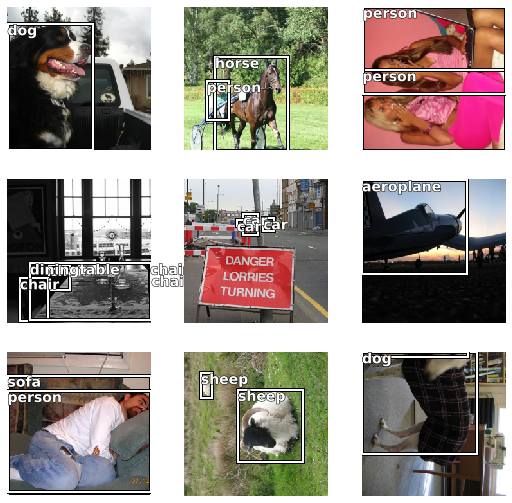

In [13]:
dls.show_batch()

In [14]:
from imports import *

In [15]:
encoder = create_body(resnet34, pretrained=True)

In [16]:
get_c(dls)

20

In [17]:
NUM_CLASSES = get_c(dls)

In [18]:
arch = RetinaNet(encoder, get_c(dls), final_bias=-4)

In [19]:
ratios = [1/2,1,2]
scales = [1,2**(-1/3), 2**(-2/3)]

In [20]:
crit = RetinaNetFocalLoss(arch, scales=scales, ratios=ratios)

In [21]:
def _retinanet_split(m): return L(m.encoder,nn.Sequential(m.c5top6, m.p6top7, m.merges, m.smoothers, m.classifier, m.box_regressor)).map(params)

In [22]:
import pdb

In [23]:
import torchvision

In [24]:
class ThresholdingAndNMS(Callback):
    def __init__(self, threshold=0.3):
        self.threshold=threshold
    def after_loss(self):
        if self.training: return # only do this expensive computation during validation/show_results
        box_pred, cls_pred = self.learn.pred
        scores = torch.sigmoid(cls_pred)
        anchors = self.learn.loss_func.anchors
        recovered_boxes = torch.clamp(cthw2tlbr(activ_to_bbox(box_pred, anchors).view(-1,4)).view(*box_pred.shape), min=-1, max=1)
        cls_clean, box_clean = [],[]
        
        one_batch_boxes = []
        one_batch_scores = []
        one_batch_cls_pred = [] 
        for i in range(cls_pred.shape[0]):
            cur_box_pred = recovered_boxes[i]
            cur_scores = scores[i]
            max_scores, cls_idx = torch.max(cur_scores, dim=1)
            thresh_mask = max_scores > self.threshold
            
            cur_keep_boxes = cur_box_pred[thresh_mask]
            cur_keep_scores = cur_scores[thresh_mask]
            cur_keep_cls_idx = cls_idx[thresh_mask]
            
            one_img_boxes = []
            one_img_scores = []
            one_img_cls_pred = []
            for c in range(NUM_CLASSES):
                cls_mask   = cur_keep_cls_idx==c
                if cls_mask.sum()==0:
                    continue
                cls_boxes  = cur_keep_boxes[cls_mask]
                cls_scores = cur_keep_scores[cls_mask].max(dim=1)[0]
                nms_keep_idx = torchvision.ops.nms(cls_boxes,cls_scores, iou_threshold=0.5)
                one_img_boxes += [*cls_boxes[nms_keep_idx]]
                one_img_scores += [*cur_keep_scores[nms_keep_idx]]
                one_img_cls_pred += [*tensor([c]*len(nms_keep_idx))]
                
            one_batch_boxes.append(one_img_boxes)
            one_batch_scores.append(one_img_scores)
            one_batch_cls_pred.append(one_img_cls_pred)
        
        
        
        #padded_boxes, padded_cls_pred = pad_and_merge(one_batch_boxes, one_batch_cls_pred)
        #print(f"padded_boxes: {padded_boxes.shape} - padded_cls_pred: {padded_cls_pred.shape}")
        #self.learn.pred = to_device((padded_boxes, padded_cls_pred), cls_pred.device)
        padded_boxes, padded_scores = pad_and_merge_scores(one_batch_boxes, one_batch_scores)
        #print(f"padded_boxes: {padded_boxes.shape} - padded_scores: {padded_scores.shape}")
        self.learn.pred = to_device((padded_boxes, padded_scores), cls_pred.device)

In [25]:
def pad_and_merge_scores(boxes_batch, scores_batch):
    max_n_boxes = max([len(boxes_img) for boxes_img in boxes_batch])
    
    padded_boxes = torch.zeros(len(boxes_batch), max_n_boxes, 4).float()
    padded_scores = torch.zeros(len(boxes_batch), max_n_boxes, NUM_CLASSES).float()
    padded_scores[:,:] = 10 # set all to 10, if its a padded box, this is very ugly, the metric will remove 
    # these rows
    
    for i, (boxes_img, scores_img) in enumerate(zip(boxes_batch, scores_batch)):
        for j, (box, score) in enumerate(zip(boxes_img, scores_img)):
            padded_boxes[i,j] = box
            padded_scores[i,j] = score
    return (TensorBBox(padded_boxes), TensorMultiCategory(padded_scores))

In [26]:
from object_detection_metrics.BoundingBox import BoundingBox, BBType, BBFormat
from object_detection_metrics.BoundingBoxes import BoundingBoxes
from object_detection_metrics.Evaluator import Evaluator

In [27]:
def tlbr2xyxy(box, img_size=(224,224)):
    h,w = img_size  # ????
    # assume shape = (4)
    # converting from pytorch -1 to 1 -> 0 to 1
    #print(f"box shape: {box.shape}")
    box = box.squeeze()
    box = (box + 1) / 2
    x1 = int(box[0]*w)
    x2 = int(box[2]*w)
    y1 = int(box[1]*h)
    y2 = int(box[3]*h)
    return [x1,y1,x2,y2]



class mAP(Metric):
    def __init__(self):
        self.boxes = BoundingBoxes()
        self.count = 0
        self.res = None
    
    def reset(self):
        self.boxes.removeAllBoundingBoxes()
        self.count = 0
    
    def accumulate(self, learn):
        # add predictions and ground truths
        #pdb.set_trace()
        pred_boxes, pred_scores = learn.pred
        # remove padded boxes in batch
        pred_cls = pred_scores.argmax(dim=-1)
        gt_boxes, gt_cls = learn.yb
        #pdb.set_trace()
        for img_box_pred, img_score_pred, img_box_gt, img_cls_gt in zip(pred_boxes, pred_scores, gt_boxes, gt_cls): 
            
            pred_nonzero_idxs = (img_score_pred.sum(dim=-1) < 5).float().nonzero()
            #pdb.set_trace()
            if not pred_nonzero_idxs.numel() == 0:
                img_cls_pred = img_score_pred[pred_nonzero_idxs].argmax(dim=-1)
                #pdb.set_trace()
                #add predictions for this img
                for box_pred, cls_pred, score_pred in zip(img_box_pred[pred_nonzero_idxs], img_cls_pred, img_score_pred[pred_nonzero_idxs]):
                    b = BoundingBox(self.count, learn.dls.vocab[cls_pred.item()+1], *tlbr2xyxy(box_pred), 
                                bbType=BBType.Detected, format=BBFormat.XYX2Y2, classConfidence=score_pred.squeeze()[cls_pred.item()])
                    self.boxes.addBoundingBox(b)
                    #print(f"adding detection {learn.dls.vocab[cls_pred.item()]}")
             #       pdb.set_trace()
            
            gt_nonzero_idxs   = img_cls_gt.nonzero()#.squeeze()
            for box_gt, cls_gt in zip(img_box_gt[gt_nonzero_idxs], img_cls_gt[gt_nonzero_idxs]):
                b = BoundingBox(self.count, learn.dls.vocab[cls_gt.item()], *tlbr2xyxy(box_gt), 
                            bbType=BBType.GroundTruth, format=BBFormat.XYX2Y2)
                self.boxes.addBoundingBox(b)
                #print(f"adding gt {learn.dls.vocab[cls_gt.item()]}")
          #      pdb.set_trace()
            # increment counter
            self.count += 1
    
    @property
    def value(self):
        if len(self.boxes.getBoundingBoxes()) == 0:
            return 0
        self.res = Evaluator().GetPascalVOCMetrics(self.boxes)
        return np.mean([cat["AP"] for cat in self.res])
    
    @property
    def name(self):
        return "mAP"

In [28]:
class LookUpMetric(Metric):
    def __init__(self, reference_metric, metric_name, lookup_idx):
        store_attr(self, "reference_metric,metric_name,lookup_idx")
    
    def reset(self):
        pass
    def accumulate(self, learn):
        pass
    
    @property
    def value(self):
        if self.reference_metric.res is None:
            _ = self.reference_metric.value
        return self.reference_metric.res[self.lookup_idx]["AP"]
    
    @property
    def name(self):
        return self.metric_name + "AP"
    

In [29]:
map_metric = mAP()
metrics = [map_metric]

In [30]:
for lookup_idx in range(NUM_CLASSES):
    metrics.append(LookUpMetric(map_metric, dls.vocab[lookup_idx+1], lookup_idx))

In [31]:
learn = Learner(dls, arch, loss_func=crit, splitter=_retinanet_split, 
                cbs=[ThresholdingAndNMS()], metrics=metrics)

In [32]:
learn.to_fp16()

In [33]:
learn.freeze()

In [34]:
learn.fit_one_cycle(10, lr_max=slice(5e-5,5e-4))

epoch,train_loss,valid_loss,mAP,aeroplaneAP,bicycleAP,birdAP,boatAP,bottleAP,busAP,carAP,catAP,chairAP,cowAP,diningtableAP,dogAP,horseAP,motorbikeAP,personAP,pottedplantAP,sheepAP,sofaAP,trainAP,tvmonitorAP,time
0,3.191086,2.466130,0.001636,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0,0.018268,0.000000,0,0.014454,0,0.000000,0,0,0,00:31
1,2.671774,2.204003,0.002571,0.000000,0,0.000024,0.000000,0,0,0.010701,0,0.000321,0.000000,0.000000,0.015291,0.000456,0,0.016308,0,0,0.000446,0.007387,0.000493,00:31
2,2.552392,2.247880,0.001845,0.000000,0,0,0.000000,0,0,0.000265,0,0.000240,0.000000,0,0.000000,0.008372,0,0.012531,0.000000,0.000000,0,0.015501,0.000000,00:28
3,2.300665,1.960267,0.016573,0.051628,0.000000,0.032516,0.000256,0.000000,0,0.030517,0.063140,0.002152,0,0.004762,0.034722,0.023256,0.027027,0.032270,0,0,0.004870,0.024341,0.000000,00:29
4,2.104755,1.926525,0.028239,0.045113,0.010638,0.123560,0.000000,0.000000,0.003854,0.031164,0.145173,0.000919,0.004038,0.004107,0.023172,0.047647,0.007432,0.051678,0.004762,0.000000,0.007006,0.054331,0.000186,00:30
5,1.944578,1.894258,0.032758,0.082554,0.000000,0.055135,0.000467,0.000000,0.054999,0.054165,0.159951,0.004575,0.004754,0.000000,0.030244,0.039273,0.008108,0.059211,0.000000,0.016667,0.004977,0.077867,0.002217,00:32
6,1.834828,1.802596,0.044754,0.078070,0.031455,0.130804,0,0.000000,0.000000,0.067521,0.246648,0.001888,0.013680,0.010989,0.061411,0.052793,0.042480,0.047825,0.000461,0.001102,0.033625,0.070832,0.003497,00:30
7,1.740195,1.669592,0.054721,0.106629,0.004559,0.140175,0.000821,0.006849,0.033387,0.088117,0.303579,0.005701,0.003602,0.012085,0.073931,0.081816,0.023133,0.063171,0.014286,0.018590,0.019800,0.088449,0.005737,00:30
8,1.659531,1.671410,0.061309,0.159929,0.021098,0.124933,0.013642,0.016065,0.080645,0.092167,0.285527,0.012925,0.007284,0.004496,0.130448,0.064711,0.016424,0.070987,0.004286,0.018377,0.020748,0.077988,0.003497,00:30
9,1.611712,1.664678,0.063434,0.203753,0.004451,0.110366,0.000000,0.009132,0.144665,0.088732,0.328819,0.007882,0.005442,0.008791,0.095140,0.039543,0.043528,0.058207,0.000571,0.003581,0.012019,0.099880,0.004181,00:29


In [35]:
learn.save("freeze-10")

In [36]:
learn.unfreeze()

In [37]:
learn.fit_one_cycle(15, lr_max=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,mAP,aeroplaneAP,bicycleAP,birdAP,boatAP,bottleAP,busAP,carAP,catAP,chairAP,cowAP,diningtableAP,dogAP,horseAP,motorbikeAP,personAP,pottedplantAP,sheepAP,sofaAP,trainAP,tvmonitorAP,time
0,1.530233,1.664031,0.061987,0.215321,0.006353,0.078244,0.000595,0.010274,0.040887,0.089504,0.390575,0.009076,0.002401,0.001893,0.069370,0.058348,0.025270,0.055231,0.024839,0.018523,0.028628,0.107118,0.007301,00:32
1,1.535186,1.592361,0.080390,0.201461,0.017698,0.115927,0.002646,0.006489,0.171252,0.098014,0.392222,0.007737,0.005873,0.035231,0.113417,0.097887,0.066343,0.072896,0.009286,0.006618,0.030057,0.139305,0.017437,00:30
2,1.531410,1.665028,0.071500,0.244221,0.009024,0.115343,0.000000,0.011809,0.067903,0.107279,0.390776,0.014327,0.002661,0.013393,0.086574,0.048662,0.042173,0.076945,0.004756,0.007444,0.051921,0.127413,0.007382,00:31
3,1.510005,1.636458,0.087217,0.259420,0.034460,0.098287,0.003968,0.038948,0.145063,0.096291,0.474755,0.005171,0.001870,0.009564,0.151523,0.080345,0.052936,0.062471,0.015017,0.003922,0.016113,0.167407,0.026805,00:31
4,1.483861,1.558743,0.085388,0.235005,0.016493,0.135730,0.006349,0.035521,0.079794,0.106409,0.471152,0.002765,0.012219,0.031471,0.152730,0.050469,0.060362,0.075115,0.017248,0.005333,0.040360,0.147584,0.025642,00:31
5,1.453249,1.593590,0.103214,0.308290,0.106341,0.163552,0.003081,0.014456,0.156477,0.119498,0.416622,0.006418,0.041896,0.024557,0.189278,0.051599,0.108805,0.072118,0.020134,0.011742,0.052985,0.168586,0.027836,00:32
6,1.420243,1.543469,0.093189,0.300750,0.010638,0.196482,0.011905,0.039660,0.037220,0.091856,0.425204,0.007838,0.029943,0.009241,0.178885,0.098652,0.056904,0.076092,0.018677,0.004861,0.060360,0.187459,0.021155,00:31
7,1.383124,1.533705,0.086238,0.296275,0.018133,0.170682,0.018465,0.023954,0.136369,0.097017,0.331593,0.003863,0.009029,0.016671,0.150036,0.065232,0.042792,0.069482,0.025624,0.022222,0.032850,0.185564,0.008916,00:31
8,1.353839,1.488037,0.108945,0.361871,0.051208,0.186427,0.008333,0.030146,0.171381,0.130575,0.407535,0.007991,0.004963,0.046703,0.212123,0.094486,0.086284,0.093945,0.033791,0.027778,0.021542,0.180997,0.020824,00:30
9,1.318299,1.517780,0.096727,0.210114,0.050462,0.185324,0.009974,0.027785,0.132541,0.104728,0.394587,0.012301,0.013903,0.007901,0.199494,0.069568,0.123684,0.075771,0.013998,0.021925,0.065355,0.177311,0.037815,00:32


In [38]:
learn.save("unfreeze-15")

/home/jaidmin/anaconda3/envs/fastai2/lib/python3.7/site-packages/torch/nn/functional.py:2751: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
/home/jaidmin/anaconda3/envs/fastai2/lib/python3.7/site-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "


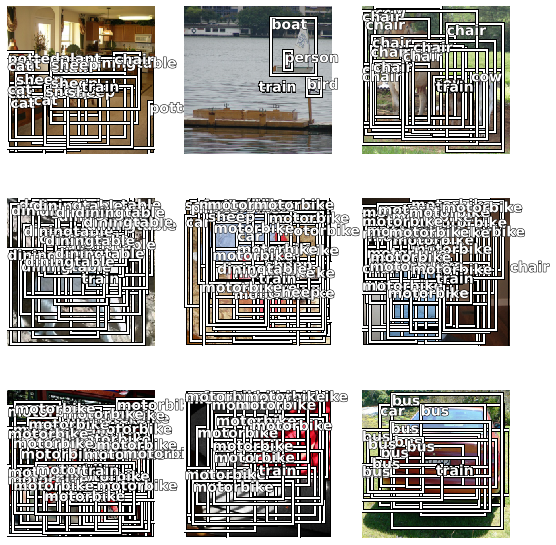

In [39]:
learn.show_results()

In [45]:
learn.cbs[3].threshold = 0.4

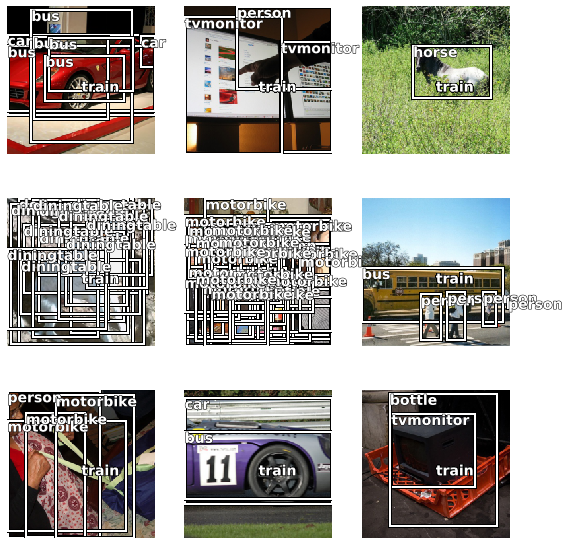

In [46]:
learn.show_results()